# Data analysis: Fitting the filter transfer function

:::{admonition} Goals
:class: tip
-  Learn how to load and fit a model to data using Python
:::

<span style='color:red'>OBS:Antes de usar este notebook, faça-te um favor e instale o Python através da distribuição Anaconda. Deve ser utilizado o Python versão >3.</span>
https://www.anaconda.com/download/


## Loading python packages
The following python packages will be necessary to execute this notebook

In [1]:
'''importa as bibliotecas necessárias'''
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import time          # importar a bilioteca para funções temporais
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os            # biblioteca para lidar com diretórios
import scipy.io #pacote para carregar dados do matlab
from scipy.optimize import curve_fit # pacote para ajuste de curvas
from uncertainties import ufloat # pacote para lidar com incertezas
#from scipy import optimize
%matplotlib inline   

## Loading data
Carregando arquivos com o pacote PANDAS. O arquivo ```.csv``` deverá estar na mesma pasta que o seu arquivo Jupyter

In [2]:
file_name = 'dados_sweep.csv'
folder_path=os.getcwd()    
file=os.path.join(folder_path,file_name)
dados = pd.read_csv(file, sep=',') #separador ,
#ver o cabeçalho....
dados.head()

,Unnamed: 0,frequencia (Hz),Vpp1 (V),Vpp2 (V),fase (rad)
0,0,10.000000,2.008803,1.999977,0.360000
1,1,13.738238,2.021052,1.993670,-0.494505
2,2,18.873918,1.996554,1.987532,-0.271903
3,3,25.929438,1.996554,1.993721,-1.867220
4,4,35.622479,1.996554,1.987511,-1.538462


In [3]:
#*********************************************
#atribuindo variáveis
#*********************************************
freq_vec =  np.array(dados['frequencia (Hz)'])
vpp1_vec =  np.array(dados['Vpp1 (V)'] )
vpp2_vec =  np.array(dados['Vpp2 (V)'] )
fase_vec =  np.array(dados['fase (rad)'])
npt = len(vpp1_vec) # numero de pontos

Em termos das amplitudes (pico-pico) medidas no osciloscópio, a transmitância é dada por 

$$T=\left(\frac{v_{out}^{(pp)}}{v_{in}^{(pp)}}\right)^2$$(eq:trans_lin)

Em decibéis, 

$$T_{dB}=10\log_{10}(T)$$(eq:trans_db)

As equações {eq}`eq:trans_lin` e {eq}`eq:trans_db` são calculadas a seguir:

In [4]:
#*********************************************
#calculando transmistancia a partir dos vetores de vpp
#*********************************************
t = (vpp2_vec/vpp1_vec)**2
t_db = 10*np.log10(t)
#*********************************************
#---------------------------
#horizontal [segundos]
fase_vec_rad=fase_vec*np.pi/180 #fase em radianos
omega_vec = 2*np.pi*freq_vec # frequencia angular
#*********************************************
#recortando os vetores, caso possuam ponto a serem excluidos
#*********************************************
pi = 0 # indice do primeiro ponto
pf = npt # indice do último ponto
freq_vecr = freq_vec[pi:pf]
tr = t[pi:pf]
t_dbr = t_db[pi:pf]
fase_vecr = fase_vec[pi:pf]

<Figure size 432x288 with 0 Axes>

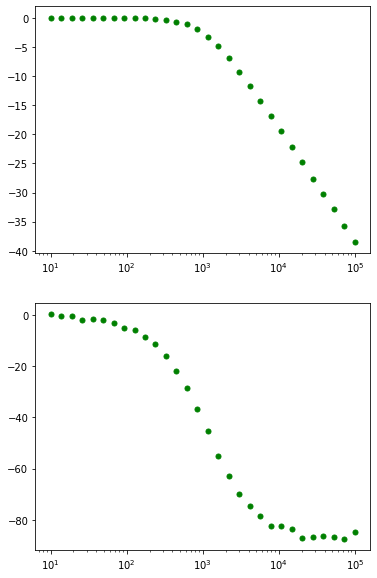

In [5]:
#*********************************************
#grafico
#*********************************************
fig = plt.figure();
fig, ax = plt.subplots(2, sharex=True, figsize=(6, 10))
ax1 = plt.subplot(211);
ax2 = plt.subplot(212);
#DADOS
#*********************************************
#grafico experimental
ax1.semilogx(freq_vecr,t_dbr, 'og', markersize=5, label='dados')
ax2.semilogx(freq_vecr,fase_vecr,'og', markersize=5)

fig; # mostra a figura


Na célula abaixo, definimos funções para calcular a função de transferência complexa para um circuito $RC$, a transmitância e a fase de função de transferência
$$H(\omega,R,C)=\frac{Z_c}{R+Zc}=\frac{-j/(\omega C)}{R-j/(\omega C)};$$ 
a transmitância $$T(\omega,R,C)=|H(\omega,R,C)|^2;$$
e a fase da função de transferência $$\phi(\omega,R,C)=\arg(H(\omega,R,C)).$$

Explicitamos acima a dependência com os parâmetros $R$ e $C$ para lembrá-los que estes parâmetros devem ser considerados no caso de outro circuito, e.g., no $RL$ devemos ter uma função que depende de $R,L$

In [6]:
#*********************************************
#definindo funcao que calcula a curva teorica
#r - resistencia
#c - capacitancia
#*********************************************
def funcH(freq, r, c):
    j=complex(0,1)
    omega=2*np.pi*freq
    #reatancias
    Xc=1/(omega*c)
    #impedancias
    Zc=-j*Xc
    #funcao de transferencia
    H= Zc/(r+Zc)
    return H
def funcT(freq, r, c):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    H = funcH(freq, r, c)
    #transmitancia, linear
    T = np.abs(H)**2
    return T
def funcTdb(freq, r, c):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    H = funcH(freq, r, c)
    #transmitancia, linear
    Tdb = 20*np.log10(np.abs(H))
    return Tdb
def funcPhi(freq, r, c):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    #Funcao H
    H = funcH(freq, r, c)
    #fase em graus
    phi = np.angle(H,deg=True)
    return phi

In [7]:
chute_inicial = (150,0.22e-6,) #chute inicial igual parametros nominais
pfit, pcov = curve_fit(funcTdb, freq_vecr, t_dbr, p0=chute_inicial)
#print('Parametros do ajuste (r (Ohms),c (faraday)):', pfit)
#print(popt)
perr = np.sqrt(np.diag(pcov))
print("\nParâmetros ajustados segundo a função curve_fit:")
print("pfit = ", pfit)
print("\nErros estimados pela função curve_fit:")
print("perr = ", perr)


Parâmetros ajustados segundo a função curve_fit:
pfit =  [1.75694792e+02 7.81201677e-07]

Erros estimados pela função curve_fit:
perr =  [4.59981698e+07 2.04524262e-01]


O erro acima ocorre porque tentamos ajustar dois parâmetros que estão relacionados $\tau=RC$, sendo que a função de ajuste depende apenas do produto entre os dois valores. Dada esta dependencia da função de ajuste, deveríamos tentar ajustar apenas o produto $RC$. Por exemplo, a função de transferência do filtro passa-baixas pode ser escrita como $$H_{PB}(\omega)=\frac{1}{1+j\omega\tau}.$$ A seguir tratamos este caso.

In [8]:
def funcH2(freq, tau):
    j=complex(0,1)
    omega=2*np.pi*freq
    #funcao de transferencia
    H= 1/(1+j*omega*tau)
    return H
def funcTdb2(freq, tau):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    H = funcH2(freq, tau)
    #transmitancia, linear
    Tdb = 20*np.log10(np.abs(H))
    return Tdb
def funcT2(freq, tau):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    H = funcH2(freq, tau)
    #transmitancia, linear
    T = np.abs(H)**2
    return T
def funcPhi2(freq, tau):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    #Funcao H
    H = funcH2(freq, tau)
    #fase em graus
    phi = np.angle(H,deg=True)
    return phi

In [9]:
chute_inicial = (150*0.22e-6,) #chute inicial igual parametros nominais
pfit, pcov = curve_fit(funcTdb2, freq_vecr, t_dbr, p0=chute_inicial)
#print('Parametros do ajuste (r (Ohms),c (faraday)):', pfit)
#print(popt)
perr = np.sqrt(np.diag(pcov))
print("\nParâmetros ajustados segundo a função curve_fit:")
print("pfit = {:2e} ".format(pfit[0]))
print("\nErros estimados pela função curve_fit:")
print("σ = {:2e} ".format(perr[0]))


Parâmetros ajustados segundo a função curve_fit:
pfit = 1.372531e-04 

Erros estimados pela função curve_fit:
σ = 6.992647e-07 


Podemos usar o pacote uncertainty (veja no início deste notebook), para colocar o erro com os algarismos significativos corretos:

In [10]:
print("τ (com uma casa décimal)= ({:.1f}) μs".format(1e6*ufloat(pfit[0],perr[0])))
print("τ (com duas casa décimal)= ({:.2f}) μs".format(1e6*ufloat(pfit[0],perr[0])))

τ (com uma casa décimal)= (137.3+/-0.7) μs
τ (com duas casa décimal)= (137.25+/-0.70) μs


Na célula abaixo, é claro que será necessário alterar os valores dos argumentos das funções funcT e funcPhi:
```
T = funcT(freq_t,150,0.22e-6)
fase = funcPhi(freq_t,150,0.22e-6)
```
Também é assumido que você já fez as alterações necessárias nas funções para contemplar as sutilezas do seu circuito.

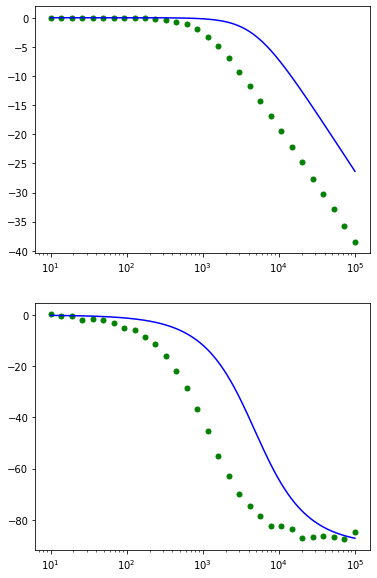

In [11]:
#*********************************************
#vetor de frequencias teorica, com bem mais pontos que o experimental
freq_t=np.logspace(np.log10(freq_vecr[0]),np.log10(freq_vecr[-1]),1000)
#transmicao teorica usando valores nominais, checar se a curva parece com o experimento
T = funcT2(freq_t,150*0.22e-6)
fase = funcPhi2(freq_t,150*0.22e-6)
#*********************************************

ax1.semilogx(freq_t,10*np.log10(T),'-b',label='teórico nominal') # curva teorica
ax2.semilogx(freq_t,fase,'-b') # curva teorica
fig

<span style='color:red'>OBS:</span>Abaixo, usamos a notação ```Tfit = funcT(freq_t, *pfit)``` para passar o argumento ```pfit```. Esta notação, que inlcui um asterísco, significa que ```pfit``` pode ser um escalar ou um vetor. No caso de ser um vetor, a sua função deverá receber tantos argumentos (após o argumento ```freq_t```) quanto elementos no vetor ```pfit```

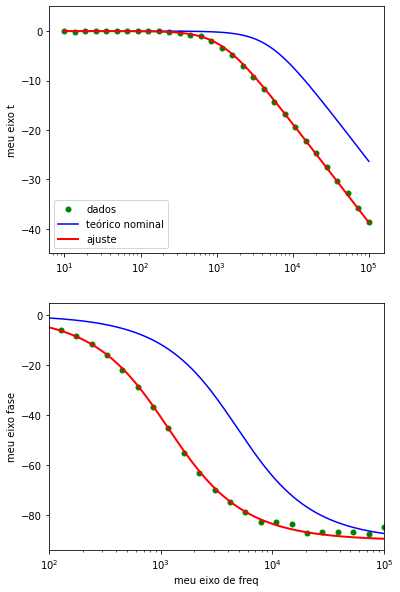

<Figure size 432x288 with 0 Axes>

In [12]:
#*********************************************
#graficando o ajuste em vermelho solido 
#calculando os a funcao teorica com os valores obtidos do ajuste
Tfit = funcT2(freq_t, *pfit)
fasefit = funcPhi2(freq_t, *pfit)

ax1.semilogx(freq_t,10*np.log10(Tfit),'-r',linewidth=2, label='ajuste')
ax2.semilogx(freq_t,fasefit,'-r',linewidth=2)

#ajustes dos graficos
#ax1.set_xlabel('meu eixo freq')
ax1.set_ylabel('meu eixo t')
ax2.set_xlabel('meu eixo de freq')
ax2.set_ylabel('meu eixo fase')
ax2.set_xlim((100,1e5)) #LIMITES DO EIXO X
#ax2.set_xlim((100,1e5))
ax1.set_ylim((-45,5)) #LIMITES DO EIXO Y
#ax1.legend(loc='lower right')
#plt.title('Diagrama Bode')
fig.tight_layout
plt.subplots_adjust(hspace=0.5)
#plt.subplots_adjust(wspace=0.4)
ax1.legend(loc='lower left')
fig

In [13]:
#salvando
print('pasta atual:',os.getcwd())  
name='bode_rc_dados'
folder_path=os.getcwd()
ext='pdf'
path=os.path.join(folder_path,name + '.' + ext)
fig.savefig(path,format='pdf')
print('arquivo salvo:',path)

pasta atual: /Users/gsw/Documents/GitHub/F540_jbook/guides/exp1


arquivo salvo: /Users/gsw/Documents/GitHub/F540_jbook/guides/exp1/bode_rc_dados.pdf
